## Accounting for Viscosity

This example provides a simple demonstration of how to account for the effects of temperature on viscosity.  The impacts of viscosity on the
movement of a plume are visualized with a 2D plot at the end of the notebook.

The base model setup uses the third MT3DMS demonstration model titled, "Two-Dimensional Transport in a Uniform Flow Field."  A scenario model, embedded in the same MODFLOW 6 simulation, adds a GWE model for use with the viscosity package

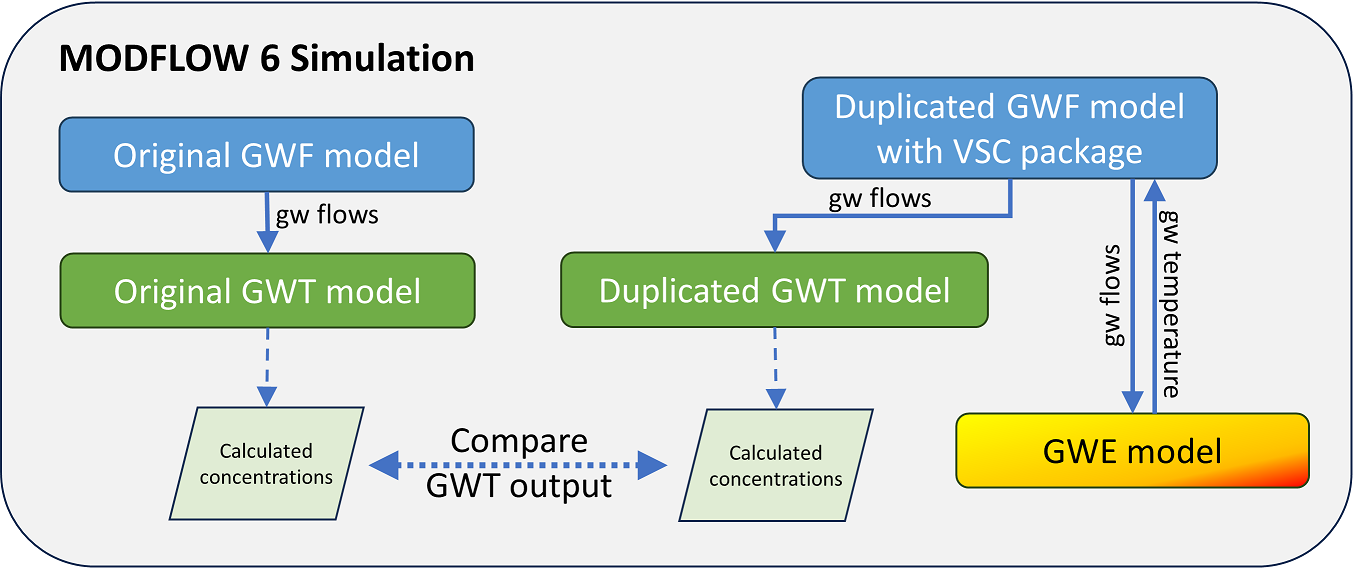

In [ ]:
# Import dependencies
import os
from pathlib import Path

import flopy
import git
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import numpy as np
import numpy.ma as ma
from flopy.plot.styles import styles
from flopy.mf6 import MFSimulation
from modflow_devtools.misc import get_env, timed

### A function for customizing colormaps used later in the notebook

In [ ]:
# A function for customizing colormaps
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

### Set simulation name and workspace

In [ ]:
sim_name = "gwt-gwe-vsc"
sim_ws = Path("../data/gwt-gwe-vsc")

### Set some model input values

In [ ]:
# Model units
length_units = "meters"
time_units = "days"

# Set some values for establishing model parameters
nlay = 1  # Number of layers
nrow = 31  # Number of rows
ncol = 46  # Number of columns
delr = 10.0  # Column width ($m$)
delc = 10.0  # Row width ($m$)
delz = 10.0  # Layer thickness ($m$)
top = 0.0  # Top of the model ($m$)
prsity = 0.3  # Porosity
perlen = 365  # Simulation time ($days$)
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)
qwell = 1.0  # Volumetric injection rate ($m^3/d$)
cwell = 1000.0  # Concentration of injected water ($mg/L$)
al = 10.0  # Longitudinal dispersivity ($m$)
trpt = 0.3  # Ratio of transverse to longitudinal dispersivity
viscref = 8.904e-4  # Reference viscosity ($\frac{kg}{m \cdot sec}$)
tform = "nonlinear"  # Viscosity representation ($-$)
a2 = 10.0  # User-specified parameter in nonlinear formulation ($-$)
a3 = 248.37  # User-specified parameter in nonlinear formulation ($-$)
a4 = 133.16  # User-specified parameter in nonlinear formulation ($-$)
iviscspec = 0  # Species ID for use in a VSC package ($-$)
dviscdc = 0.0  # not used for the nonlinear formulation, but must be specified
cviscref = 20.0  # Reference temperature for viscosity ($^{\circ}C$)
gw_temp = 4.0  # Groundwater temperature ($^{\circ}C$)
scheme = "TVD"  # Advection scheme ($-$)
sconc = 0.0  # Starting concentration ($mg/L$)
cps = 800.0  # Heat capacity of aquifer material ($\frac{J}{kg \cdot ^{\circ} C}$)
cpw = 4180.0  # Heat capacity of water ($\frac{J}{kg \cdot ^{\circ} C}$)
rhow = 1000.0  # Density of water ($kg/m^3$)
rhos = 1200.0  # Density of dry solid aquifer material ($kg/m^3$)
lhv = 2500.0  # Latent heat of vaporization ($kJ/kg$)
kts = 0.25  # Thermal conductivity of the aquifer material ($\frac{W}{m \cdot ^{\circ} C}$)
ktw = 0.58  # Thermal conductivity of water ($\frac{W}{m \cdot ^{\circ} C}$)

# Timing information
perlen = [1, 365.0]
nper = len(perlen)
nstp = [2, 730]
tsmult = [1.0, 1.0]

# Set some additional parameters
ath1 = al * trpt
botm = [top - delz]  # Model geometry
k33 = k11  # Vertical hydraulic conductivity ($m/d$)
icelltype = 0
kts *= 86400
ktw *= 86400

# Initial conditions
Lx = (ncol - 1) * delr
v = 1.0 / 3.0
prsity = 0.3
q = v * prsity
h1 = q * Lx
strt = np.zeros((nlay, nrow, ncol), dtype=float)
strt[0, :, 0] = h1

idomain = np.ones((nlay, nrow, ncol), dtype=int)
c0 = 0.0
cncspd = [[(0, 0, 0), c0]]

In [ ]:
# Set solver parameter values (and related)
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
ttsmult = 1.0

# Time discretization
tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

### Function for defining GWF models

Since multiple GWF models will be added to the MODFLOW 6 simulation, define a function to do the work multiple times.

**Note**: The function call accepts a boolean that, when passed as 'True,' will create a GWF model that includes the viscosity package.  The viscosity package is setup to recognize temperatures calculated by a GWE model that gets the calculated flows from the same GWF model with the viscosity package.

In [ ]:
def add_gwf_model(sim, gwfname, activate_vsc):
    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=np.ones((nlay, nrow, ncol), dtype=int),
        filename=f"{gwfname}.dis",
    )

    # Instantiating MODFLOW 6 node-property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=False,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
        filename=f"{gwfname}.npf",
    )

    # Instantiating MODFLOW 6 initial conditions package for flow model
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiate MODFLOW 6 storage package
    flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, filename=f"{gwfname}.sto")

    global aux_names
    global wel_spd
    if activate_vsc:
        aux_names = ["CONCENTRATION", "TEMPERATURE"]
        wel_spd = {0: [[(0, 15, 15), qwell, cwell, gw_temp]]}  # MF6 pumping information
    else:
        aux_names = ["CONCENTRATION"]
        wel_spd = {0: [[(0, 15, 15), qwell, cwell]]}  # MF6 pumping information

    # Instantiate the wel package
    flopy.mf6.ModflowGwfwel(
        gwf,
        print_input=True,
        print_flows=True,
        stress_period_data=wel_spd,
        save_flows=False,
        auxiliary=aux_names,
        pname="WEL-1",
        filename=f"{gwfname}.wel",
    )

    # Instantiating MODFLOW 6 constant head package
    rowList = np.arange(0, nrow).tolist()
    chdspd_l = []
    chdspd_r = []
    # Loop through the left & right sides.
    for itm in rowList:
        # first, constant head on left side of model
        if activate_vsc:
            chdspd_l.append([(0, itm, 0), h1, 0.0, gw_temp])
        else:
            chdspd_l.append([(0, itm, 0), h1, 0.0])

        # constant head on right side of model
        chdspd_r.append([(0, itm, ncol - 1), 0.0])

    # left side boundary condition
    chd_spd_l = {0: chdspd_l}
    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chd_spd_l),
        stress_period_data=chd_spd_l,
        auxiliary=aux_names,
        save_flows=False,
        pname="CHD-l",
        filename=f"{gwfname}.left.chd",
    )

    # right side boundary condition
    chd_spd_r = {0: chdspd_r}
    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd_r),
        stress_period_data=chd_spd_r,
        save_flows=False,
        pname="CHD-r",
        filename=f"{gwfname}.right.chd",
    )

    if activate_vsc:
        # Instantiate viscosity (VSC) package
        vsc_filerecord = "{}.vsc.bin".format(gwfname)
        gwename2 = sim_name + "-02"
        vsc_pd = [(iviscspec, dviscdc, cviscref, gwename2, "TEMPERATURE")]
        flopy.mf6.ModflowGwfvsc(
            gwf,
            viscref=viscref,
            viscosity_filerecord=vsc_filerecord,
            thermal_formulation=tform,
            thermal_a2=a2,
            thermal_a3=a3,
            thermal_a4=a4,
            nviscspecies=len(vsc_pd),
            packagedata=vsc_pd,
            pname="VSC",
            filename="{}.vsc".format(gwfname),
        )

    # Instantiating MODFLOW 6 output control package for flow model
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.bud",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )

    return sim

### Function for defining GWT models

Similarly, multiple GWT models will be defined.  Thus, create a function that will do the work for us multiple times.  This function will return the same GWT model setup each time it is called.

In [ ]:
def add_gwt_model(sim, gwtname):

    # Instantiating MODFLOW 6 groundwater transport package
    gwt = flopy.mf6.MFModel(
        sim,
        model_type="gwt6",
        modelname=gwtname,
        model_nam_file=f"{gwtname}.nam",
    )
    gwt.name_file.save_flows = True

    # create iterative model solution and register the gwt model with it
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwtname}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # Instantiating MODFLOW 6 transport discretization package
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=1,
        pname="DIS",
        filename=f"{gwtname}.dis",
    )

    # Instantiating MODFLOW 6 transport initial concentrations
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")

    # Instantiating MODFLOW 6 transport advection package
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")

    # Instantiating MODFLOW 6 transport dispersion package
    flopy.mf6.ModflowGwtdsp(
        gwt,
        xt3d_off=True,
        alh=al,
        ath1=ath1,
        filename=f"{gwtname}.dsp",
    )

    # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=prsity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption=None,
        bulk_density=None,
        distcoef=None,
        filename=f"{gwtname}.mst",
    )

    # Instantiating MODFLOW 6 transport constant concentration package
    flopy.mf6.ModflowGwtcnc(
        gwt,
        maxbound=len(cncspd),
        stress_period_data=cncspd,
        save_flows=False,
        pname="CNC-1",
        filename=f"{gwtname}.cnc",
    )

    # Instantiating MODFLOW 6 transport source-sink mixing package
    sourcerecarray = [
        ("WEL-1", "AUX", "CONCENTRATION"),
        ("CHD-l", "AUX", "CONCENTRATION"),
    ]
    flopy.mf6.ModflowGwtssm(
        gwt,
        sources=sourcerecarray,
        pname="SSM",
        filename=f"{gwtname}.ssm"
    )

    # Instantiating MODFLOW 6 transport output control package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwtname}.cbc",
        concentration_filerecord=f"{gwtname}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )

    return sim

### Function for defining a GWE model

For this example, only the GWF model that contains the viscosity package needs an associated GWE model.

In [ ]:
def add_gwe_model(sim, gwename):
    gwe = flopy.mf6.ModflowGwe(sim, modelname=gwename)

    # Instantiating solver for GWT
    imsgwe = flopy.mf6.ModflowIms(
        sim,
        print_option="ALL",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename="{}.ims".format(gwename),
    )
    sim.register_ims_package(imsgwe, [gwename])

    # Instantiating DIS for GWE
    flopy.mf6.ModflowGwedis(
        gwe,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=1,
        pname="DIS",
        filename="{}.dis".format(gwename),
    )

    # Instantiate Mobile Storage and Transfer package
    flopy.mf6.ModflowGweest(
        gwe,
        save_flows=True,
        porosity=prsity,
        cps=cps,
        rhos=rhos,
        packagedata=[cpw, rhow, lhv],
        pname="EST",
        filename="{}.est".format(gwename),
    )

    # Instantiate Energy Transport Initial Conditions package
    flopy.mf6.ModflowGweic(gwe, strt=gw_temp)

    # Instantiate Advection package
    flopy.mf6.ModflowGweadv(gwe, scheme=scheme)

    # Instantiate Dispersion package (also handles conduction)
    flopy.mf6.ModflowGwecnd(
        gwe,
        xt3d_off=True,
        ktw=ktw,
        kts=kts,
        pname="CND",
        filename="{}.cnd".format(gwename),
    )

    # Instantiating MODFLOW 6 transport source-sink mixing package
    # [b/c at least one boundary back is active (SFR), ssm must be on]
    sourcerecarray = [
        ("CHD-l", "AUX", "TEMPERATURE"),
        ("WEL-1", "AUX", "TEMPERATURE"),
    ]
    flopy.mf6.ModflowGwessm(
        gwe,
        sources=sourcerecarray,
        pname="SSM",
        filename="{}.ssm".format(gwename)
    )

    # Instantiate Output Control package for transport
    flopy.mf6.ModflowGweoc(
        gwe,
        temperature_filerecord="{}.ucn".format(gwename),
        saverecord=[("TEMPERATURE", "ALL")],
        temperatureprintrecord=[
            ("COLUMNS", 3, "WIDTH", 20, "DIGITS", 8, "GENERAL")
        ],
        printrecord=[("TEMPERATURE", "ALL"), ("BUDGET", "ALL")],
        filename="{}.oc".format(gwename),
    )

    return sim

### Build a MODFLOW 6 simulation

Simulation will include:
 - 2 GWF models
 - 2 GWT models
 - 1 GWE model

In [ ]:
# Set model names to have 2 of each type of model (GWF & GWE) in a
# single simulation
gwfname1 = sim_name.replace("gwe", "gwf") + "-01"
gwfname2 = sim_name.replace("gwe", "gwf") + "-02"

# Instantiate MODFLOW 6 simulation
sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

# Instantiating MODFLOW 6 time discretization
tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

# Add two gwf models to the simulation, one without VSC and one with VSC
mod_list = [(gwfname1, False), (gwfname2, True)]
for (gwfname, vsc_status) in mod_list:
    sim = add_gwf_model(sim, gwfname, vsc_status)

# Add accompanying solute transport (GWT) models to both GWF flow model
# (only the second GWF model will have an associated GWE model)
for i, (gwfname, vsc_status) in enumerate(mod_list):
    gwtname = sim_name.replace("gwe", "gwt") + "-" + str(i + 1).zfill(2)
    sim = add_gwt_model(sim, gwtname)

    # Setup flow-transport exchange mechanism
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype="GWF6-GWT6",
        exgmnamea=gwfname,
        exgmnameb=gwtname,
        filename=f"{gwtname}.gwfgwt",
    )

    if i > 0:
        gwename = sim_name + "-" + str(i + 1).zfill(2)
        sim = add_gwe_model(sim, gwename)

        # Instantiate Gwf-Gwe Exchange package
        flopy.mf6.ModflowGwfgwe(
            sim,
            exgtype="GWF6-GWE6",
            exgmnamea=gwfname,
            exgmnameb=gwename,
            filename="{}.gwfgwe".format(gwename),
        )


### Write and run the simulation

In [ ]:
sim.write_simulation(silent=False)
success, buff = sim.run_simulation(silent=False, report=True)
assert success, pformat(buff)

# Simulation should only take about ~15 seconds to run

### Graphic exploration of the impact of viscosity

In [ ]:
figure_size = (7.5, 12.5)

gwtname1 = sim.name.replace("gwe", "gwt") + "-01"
gwtname2 = sim.name.replace("gwe", "gwt") + "-02"

# Get the MF6 concentration output
gwt1 = sim.get_model(gwtname1)
gwt2 = sim.get_model(gwtname2)

conc_gwt_novsc = gwt1.output.concentration().get_alldata()
conc_gwt_wvsc = gwt2.output.concentration().get_alldata()

# Work up plot arrays
thresh = 0.001
conc_diff = conc_gwt_novsc[-1, 0] - conc_gwt_wvsc[-1, 0]
overpred_ma = ma.masked_where(conc_diff < thresh, conc_diff)
underpred_ma = ma.masked_where(conc_diff > -1*thresh, -1*conc_diff)

cmap = plt.get_cmap('jet')
under_cmap = truncate_colormap(cmap, 0.6, 0.9)
over_cmap = truncate_colormap(cmap, 0.4, 0.2)

# Create figure for scenario
sim_name = sim.name
fontsize = 12
plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]

# Create figure for simulation
fig, axes = plt.subplots(
    ncols=1,
    nrows=3,
    sharex=True,
    figsize=figure_size,
    constrained_layout=False,
    #dpi=600,
)

for idx, ax in enumerate(axes):
    mm = flopy.plot.PlotMapView(model=gwt1, ax=ax)
    mm.plot_grid(color=".5", alpha=0.2, linewidth=0.35)
    if idx == 0:
        cb_novsc = mm.plot_array(conc_gwt_novsc[-1, 0], alpha=0.5, cmap='jet', norm=LogNorm(vmin=1e-3, vmax=10))
        plt.colorbar(cb_novsc, label='Concentration, $mg/L$', shrink=0.8)
    if idx == 1:
        cb_wvsc = mm.plot_array(conc_gwt_wvsc[-1, 0], alpha=0.5, cmap='jet', norm=LogNorm(vmin=1e-3, vmax=10))  # vmin=1e-4, vmax=10, norm=LogNorm()
        plt.colorbar(cb_wvsc, label='Concentration, $mg/L$', shrink=0.8)
    if idx == 2:
        cb1 = mm.plot_array(underpred_ma, alpha=0.5, cmap=under_cmap, norm=LogNorm(vmin=0.01, vmax=10))
        cs1 = mm.contour_array(underpred_ma, levels=[0.1, 1.0, 10], colors="brown", linestyles="--")
        plt.clabel(cs1, inline=1, fontsize=fontsize, colors='k')
        cb2 = mm.plot_array(overpred_ma, alpha=0.5, cmap=over_cmap, norm=LogNorm(vmin=1e-2, vmax=4))
        cs2 = mm.contour_array(overpred_ma, levels=[0.01, 0.1, 1, 3], colors="b", linestyles="--")
        plt.clabel(cs2, inline=1, fontsize=fontsize, colors='b')
        plt.colorbar(cb1, ticks=[0.01, 0.1, 1, 10], label='Amount of Underprediction, $mg/L$', shrink=0.8)  # , fontsize=fontsize
        plt.colorbar(cb2, ticks=[0, 1, 2, 3, 4], label='Overprediction, $mg/L$', shrink=0.8)

    ax.set_aspect("equal")
    ax.set_ylabel("Y, m")
    plt.xlabel("X, m")
    #plt.tight_layout()

plt.show()